## 데이콘 HD 현대

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


# Setting
TR_PATH ='/content/drive/MyDrive/ship/train.csv'
TS_PATH = '/content/drive/MyDrive/ship/test.csv'
SUB_PATH ='/content/drive/MyDrive/ship/sample_submission.csv'

In [15]:
# data load
train = pd.read_csv(TR_PATH).drop(columns=['SAMPLE_ID'])
test = pd.read_csv(TS_PATH).drop(columns=['SAMPLE_ID'])

In [16]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

### EDA and visualization

In [17]:
# 데이터 확인
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ID                  391939 non-null  object 
 5   BREADTH             391938 non-null  float64
 6   BUILT               391939 non-null  int64  
 7   DEADWEIGHT          391939 non-null  int64  
 8   DEPTH               391938 non-null  float64
 9   DRAUGHT             391938 non-null  float64
 10  GT                  391939 non-null  int64  
 11  LENGTH              391938 non-null  float64
 12  SHIPMANAGER         391939 non-null  object 
 13  FLAG                391939 non-null  object 
 14  U_WIND              228251 non-null  float64
 15  V_WIND              228251 non-nul

information 봤을 때, 다량의 object columns 존재하고, 많은 수의 결측치가 존재하기 때문에 결측치 존재 컬럼에 대한 이해가 필요  U_WIND V_WIND AIR_TEMPERATURE BN 결측치 존재 컬럼

In [23]:
# 결측치 확인
print(train.isna().sum()) #BREADTH  DEPTH DRAUGHT LENGTH 는 결ㄹ측치가 1개 씩 존재해서 이 관측치들은 제거를 해도 괜찮을 것 같음
train.columns[train.isna().any()].tolist()
train.columns[train.isna().sum() > 1 ].tolist()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
year                       0
month                      0
day                        0
hour                       0
minute                     0
weekday                    0
dtype: int64


['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']


```
['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

풍향 u벡터 풍향 v벡터 기온 보퍼트 풍력 계급 이고 ATA 시점이 아니라 예보 정보
```


In [25]:
# 결측치가 1개인 컬럼들의 결측값 제거
columns_with_one_missing = train.columns[train.isna().sum() == 1]
df_cleaned = train.dropna(subset=columns_with_one_missing)
df_cleaned.isna().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ID                         0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
year                       0
month                      0
day                        0
hour                       0
minute                     0
weekday                    0
dtype: int64

In [29]:
#남은 결측값들의 퍼센트 확인
percent = (df_cleaned.isna().sum().max() / len(df_cleaned) ) * 100
print('결측값이 차지하는 비율 : {:.2f}%'.format(percent))

결측값이 차지하는 비율 : 42.00%


```
42%나 차지하기 때문에 결측값을 제거하기보다는 다른 방법으로 대치해야함

날씨 예보에 관한 값이기 때문에 시간으로 ATA 시간으로 가장 가까운 데이터의 값으로 대치하는 방안

-> U_WIND, V_WIND, AIR_TEMPERATURE, BN 컬럼의 결측치를 해당하는 day 값의 평균값으로 대치하는 예제 코드입니다:
```

In [47]:
# 결측치를 대치할 컬럼 리스트
columns_to_fillna = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

# 각 컬럼에 대해 결측치를 해당하는 'day' 값의 평균값으로 대치
for column in columns_to_fillna:
    df_cleaned[column] = df_cleaned.groupby('day')[column].transform(lambda x: x.fillna(x.mean()))
    test[column] = test.groupby('day')[column].transform(lambda x: x.fillna(x.mean()))


df_cleaned.isna().sum()

<ipython-input-47-0ac6c2d10221>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = df_cleaned.groupby('day')[column].transform(lambda x: x.fillna(x.mean()))
<ipython-input-47-0ac6c2d10221>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = df_cleaned.groupby('day')[column].transform(lambda x: x.fillna(x.mean()))
<ipython-input-47-0ac6c2d10221>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
CI_HOUR               0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391938 entries, 0 to 391938
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391938 non-null  object 
 1   ARI_PO              391938 non-null  object 
 2   SHIP_TYPE_CATEGORY  391938 non-null  object 
 3   DIST                391938 non-null  float64
 4   ID                  391938 non-null  object 
 5   BREADTH             391938 non-null  float64
 6   BUILT               391938 non-null  int64  
 7   DEADWEIGHT          391938 non-null  int64  
 8   DEPTH               391938 non-null  float64
 9   DRAUGHT             391938 non-null  float64
 10  GT                  391938 non-null  int64  
 11  LENGTH              391938 non-null  float64
 12  SHIPMANAGER         391938 non-null  object 
 13  FLAG                391938 non-null  object 
 14  U_WIND              391938 non-null  float64
 15  V_WIND              391938 non-nul

### 시각화

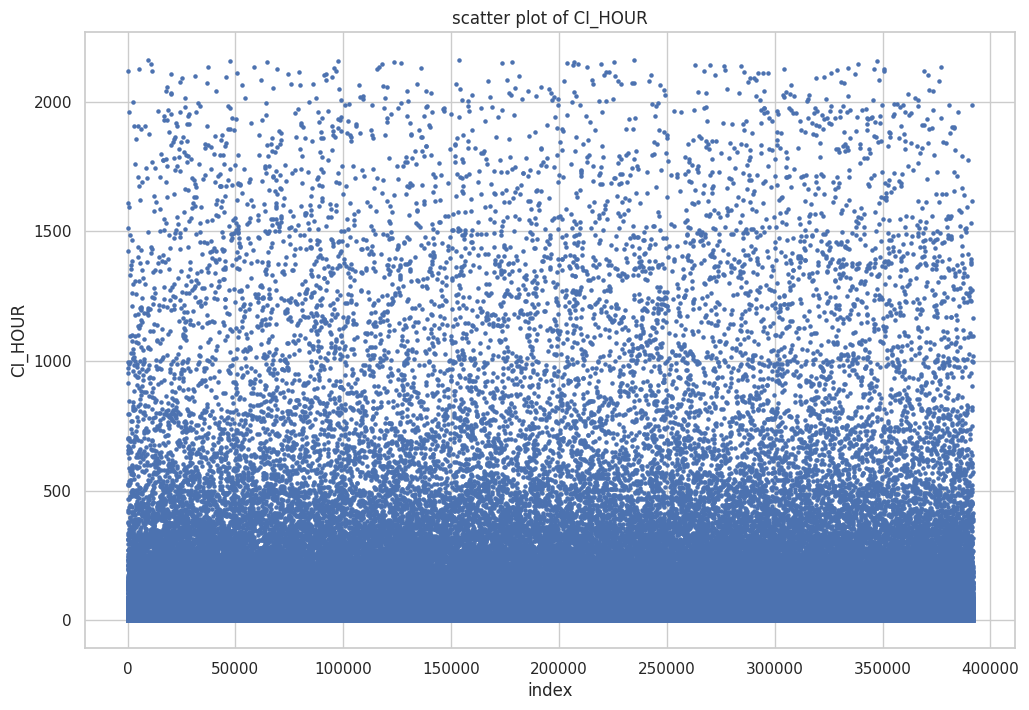

In [40]:
plt.figure(figsize=(12,8))
plt.scatter(x=df_cleaned.index,y=df_cleaned['CI_HOUR'],s=5)
plt.title('scatter plot of CI_HOUR')
plt.ylabel('CI_HOUR')
plt.xlabel('index')
plt.show()
# df_cleaned['CI_HOUR']

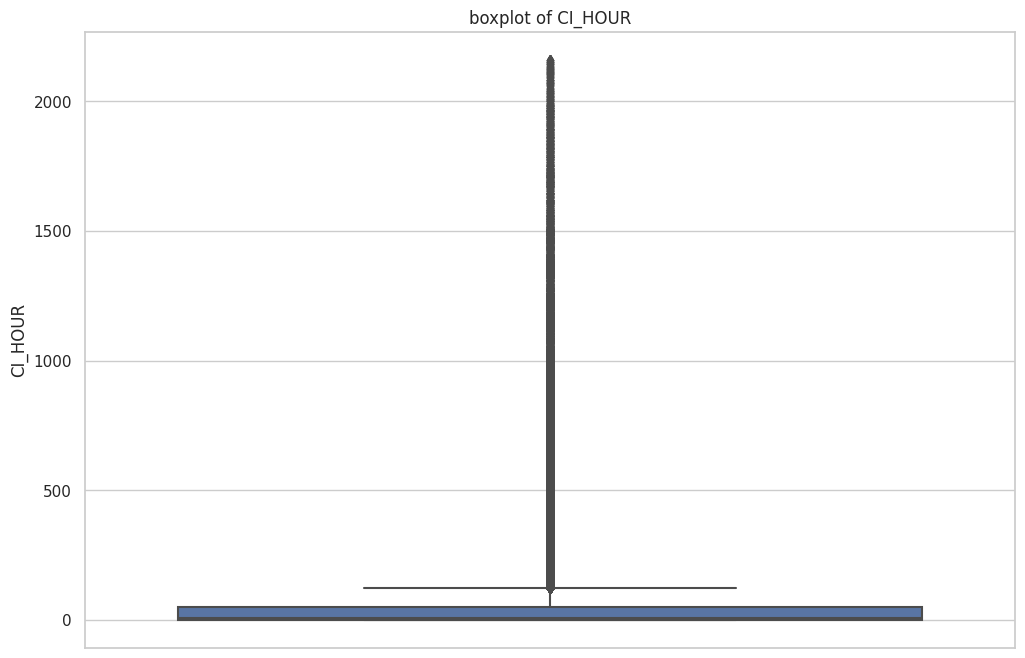

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt


# seaborn을 사용한 분포 시각화
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.boxplot(data=df_cleaned['CI_HOUR'])
plt.title('boxplot of CI_HOUR')
plt.ylabel('CI_HOUR')
plt.xticks([])
plt.show()


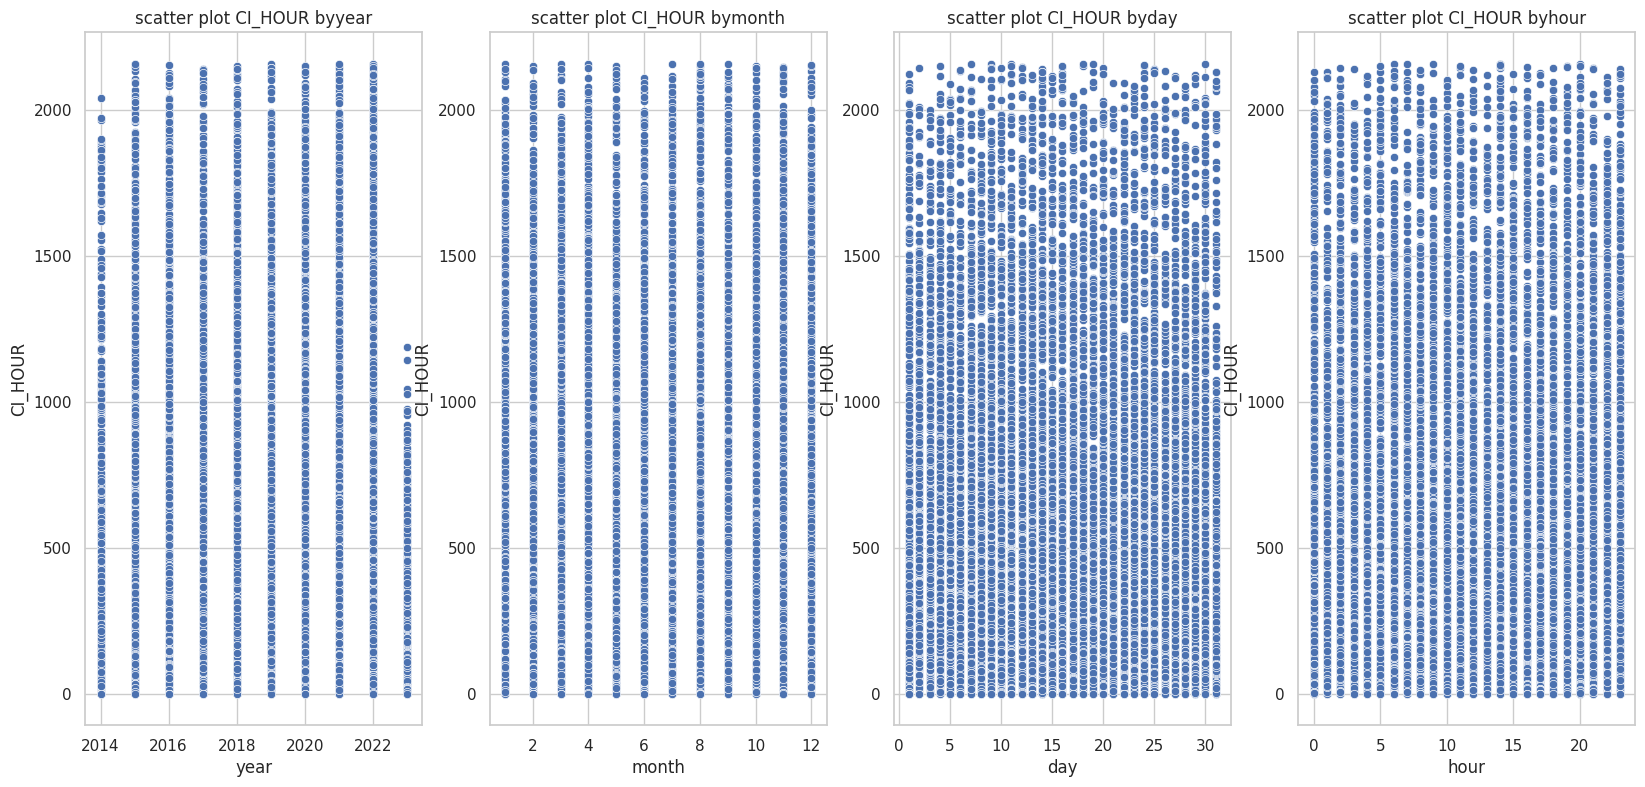

In [43]:
viz_list = ['year','month','day','hour']
plt.figure(figsize=(20,9))
for i in range(len(viz_list)):
  plt.subplot(1,4,i+1)
  sns.scatterplot(x=viz_list[i],y='CI_HOUR',data=df_cleaned)
  plt.title('scatter plot CI_HOUR by'+viz_list[i])
  plt.ylabel('CI_HOUR')
  plt.xlabel(viz_list[i])
plt.show()

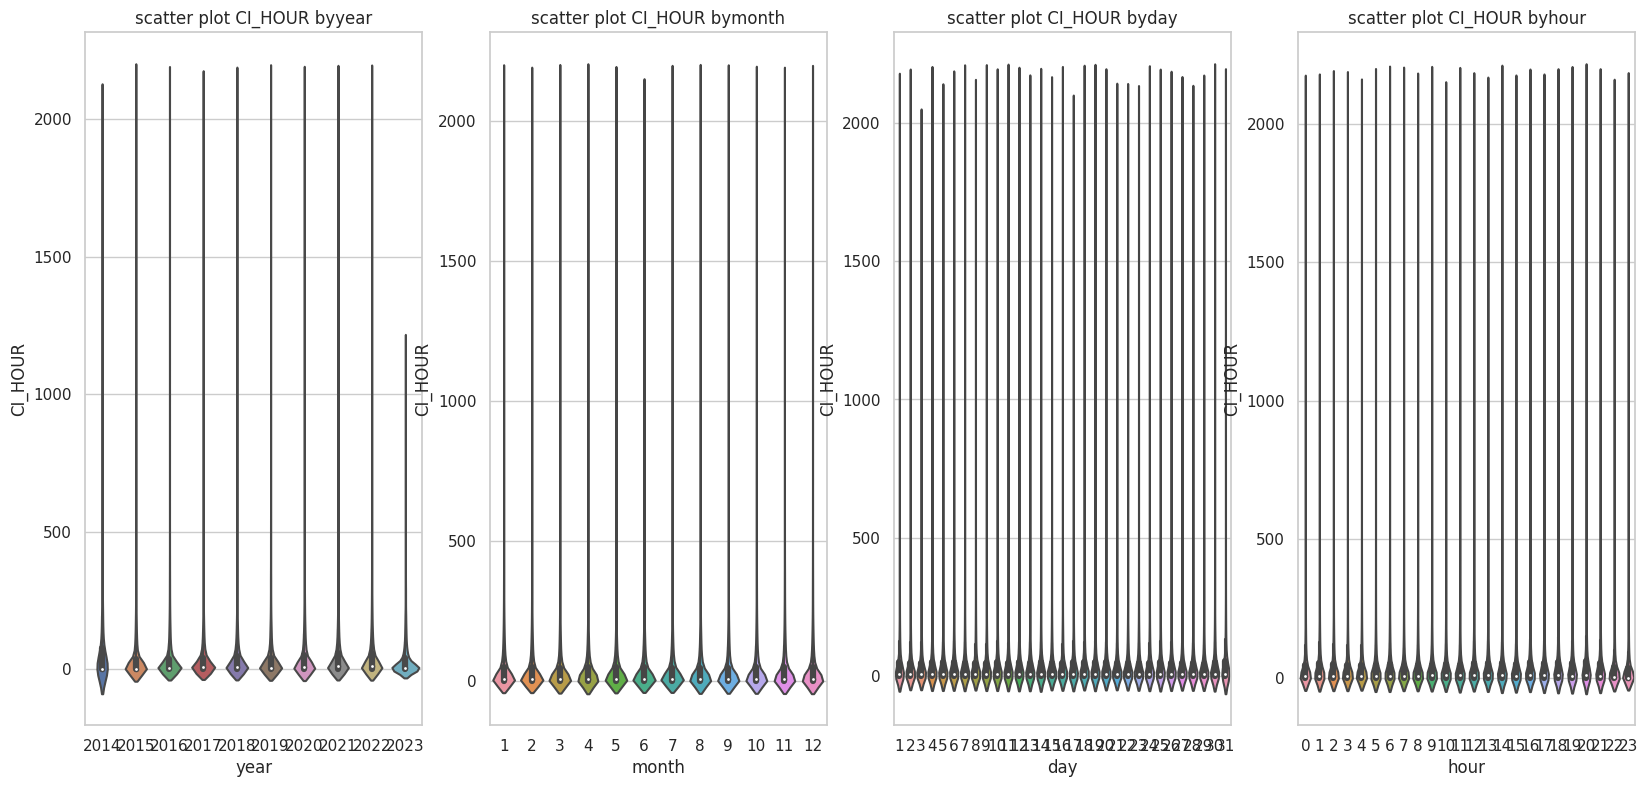

In [64]:
viz_list = ['year','month','day','hour']
plt.figure(figsize=(20,9))
for i in range(len(viz_list)):
  plt.subplot(1,4,i+1)
  sns.violinplot(x=viz_list[i],y='CI_HOUR',data=df_cleaned)
  plt.title('scatter plot CI_HOUR by'+viz_list[i])
  plt.ylabel('CI_HOUR')
  plt.xlabel(viz_list[i])
plt.show()

<ipython-input-45-10a2b6522ebe>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned.corr()


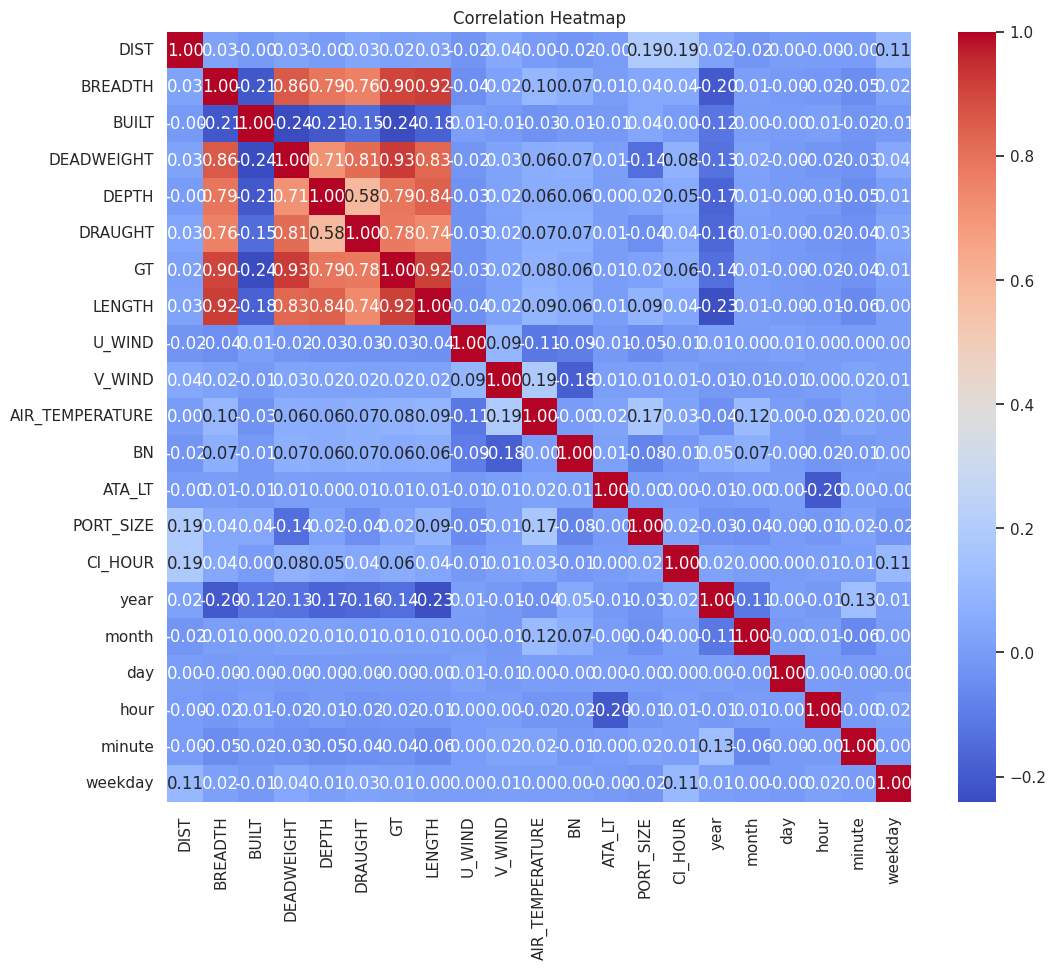

In [45]:
# df_cleaned의 상관관계 행렬
correlation_matrix = df_cleaned.corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### label encoding

In [48]:
# Categorical 컬럼 인코딩 train -> df_cleaned 로 바꿔서 ㄱㄱ
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}
for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    df_cleaned[feature] = le.fit_transform(df_cleaned[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-48-3cfbcd089f61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[feature] = le.fit_transform(df_cleaned[feature].astype(str))
Encoding features:  17%|█▋        | 1/6 [00:00<00:00,  5.62it/s]<ipython-input-48-3cfbcd089f61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[feature] = le.fit_transform(df_cleaned[feature].astype(str))
Encoding features:  33%|███▎      | 2/6 [00:00<00:00,  5.65it/s]<ipython-input-48-3cfb

## 베이스 모델 학습 및 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 391938, number of used features: 26
[LightGBM] [Info] Start training from score 61.940993


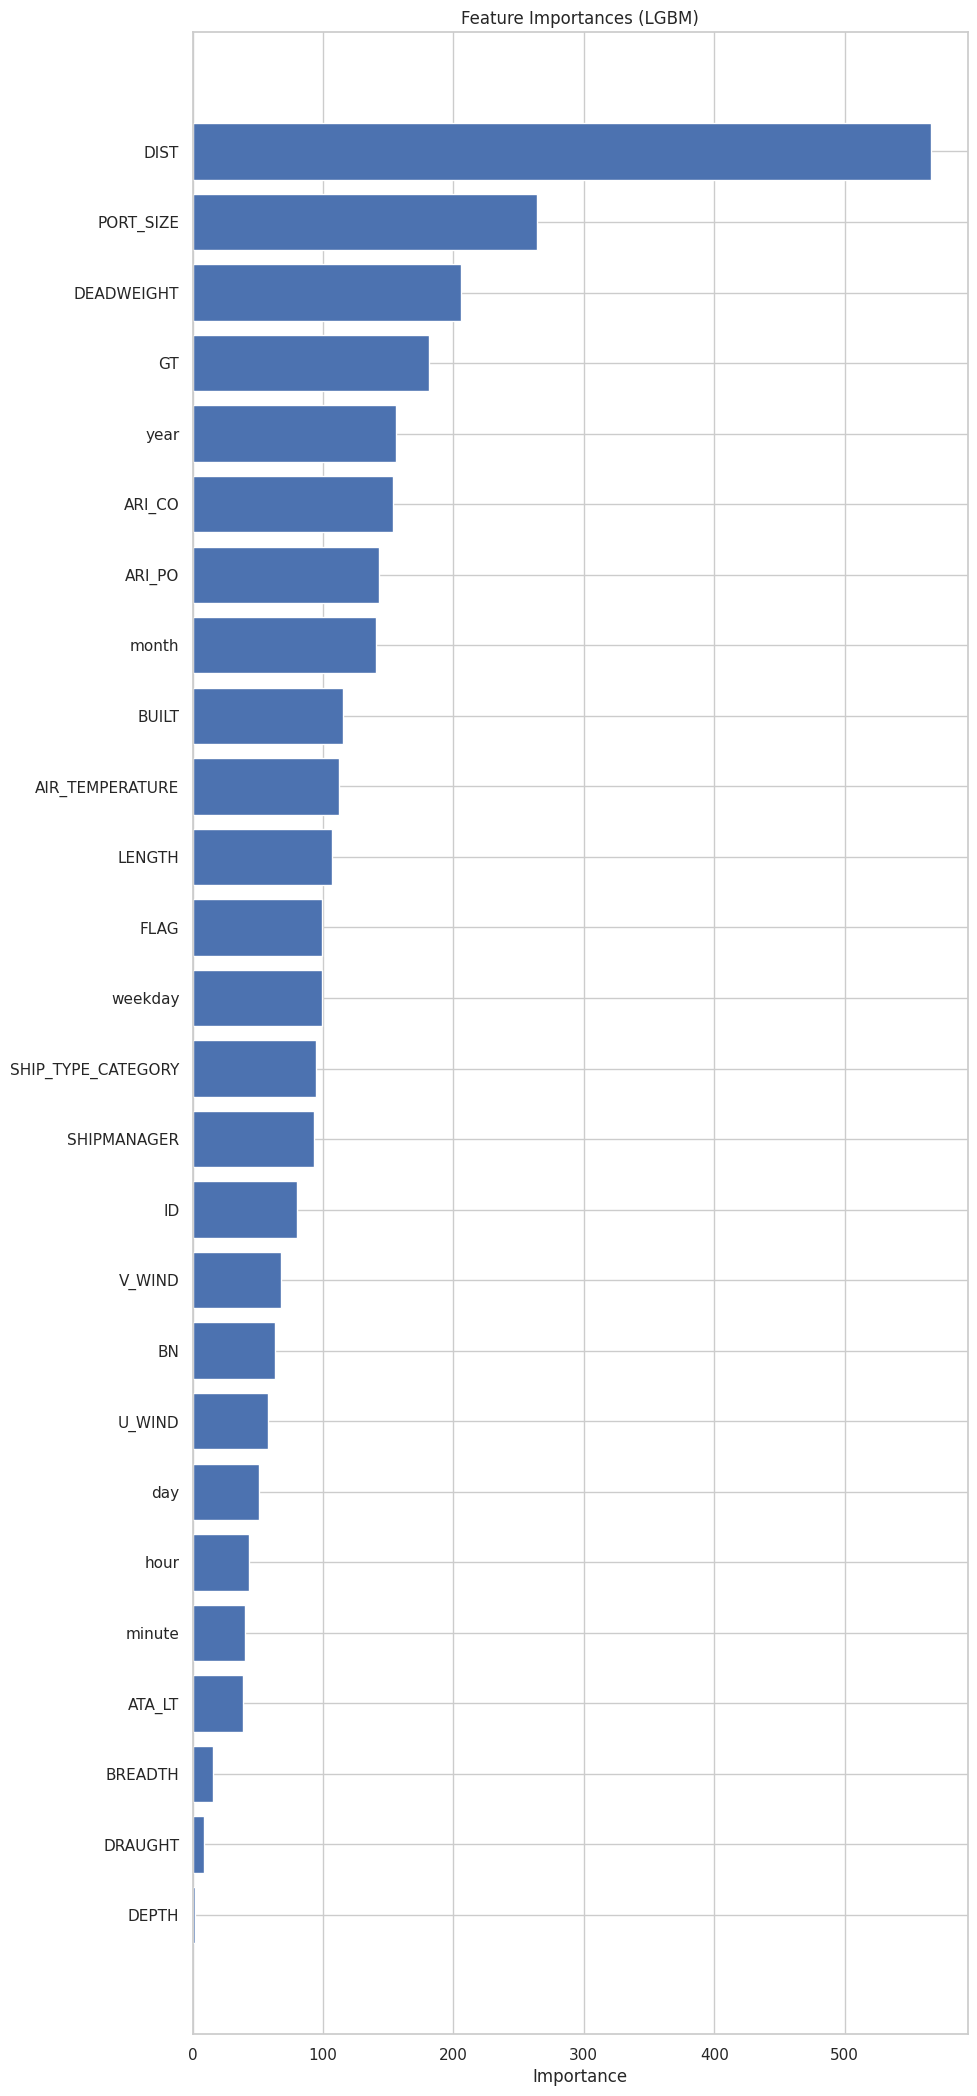

In [49]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = df_cleaned.drop(columns='CI_HOUR')
y_train = df_cleaned['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 중요도 기반으로

In [60]:
threshold = 85 # Your Threshold
df_x = df_cleaned.drop('CI_HOUR',axis=1)

low_importance_features = df_x.columns[lgbm_feature_importances < threshold]

X_train_reduced = df_x.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

### Linear regression (feature selection , full selection)

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성
model_LR_FULL = LinearRegression()

# 모델 학습
model_LR_FULL.fit(X_train, y_train)

# 학습된 모델로 예측
y_pred = model_LR_FULL.predict(X_test)

# 평가 지표 출력 (예: 평균 제곱 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mae}')


Mean Squared Error: 72.40972747747723


```
모든 features 사용한 linear regression model
```

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_selected = df_cleaned.drop('CI_HOUR',axis=1)

# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df_selected, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성
model_LR_FULL = LinearRegression()

# 모델 학습
model_LR_FULL.fit(X_train, y_train)

# 학습된 모델로 예측
y_pred = model_LR_FULL.predict(X_test)

# 평가 지표 출력 (예: 평균 제곱 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mae}')


Mean Squared Error: 72.4078077507995


```
select feature 한 LR model
```

### RANDOM FOREST (FULL & SELECTION)

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

df_selected = df_cleaned.drop('CI_HOUR',axis=1)

# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df_selected, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 생성
model_RF_FULL = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
model_RF_FULL.fit(X_train, y_train)

# 학습된 모델로 예측
y_pred = model_RF_FULL.predict(X_test)

# 평가 지표 출력 (예: 평균 제곱 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 55.462527851702035


```
모든 피쳐 사용한 Random Forest model
```

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 생성
model_RF_sl = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
model_RF_sl.fit(X_train, y_train)

# 학습된 모델로 예측
y_pred = model_RF_sl.predict(X_test)

# 평가 지표 출력 (예: 평균 제곱 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 53.84220552923722


```
select feature random forest model
```

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, y, test_size=0.2, random_state=42)

# Feature scaling (표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TensorFlow MLP 모델 생성
model_mlp = Sequential()

# 입력 레이어와 첫 번째 은닉 레이어
model_mlp.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_mlp.add(Dense(256, activation='relu'))
model_mlp.add(Dense(128, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(1))


# 모델 컴파일
model_mlp.compile(optimizer='adam', loss='mean_absolute_error')

# 모델 학습
model_mlp.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 모델 평가
y_pred = model_mlp.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Epoch 1/50
7839/7839 - 15s - loss: 49.7252 - val_loss: 47.9409 - 15s/epoch - 2ms/step
Epoch 2/50
7839/7839 - 13s - loss: 48.2038 - val_loss: 47.0132 - 13s/epoch - 2ms/step
Epoch 3/50
7839/7839 - 14s - loss: 47.4711 - val_loss: 46.7230 - 14s/epoch - 2ms/step
Epoch 4/50
7839/7839 - 13s - loss: 47.1159 - val_loss: 46.4894 - 13s/epoch - 2ms/step
Epoch 5/50
7839/7839 - 14s - loss: 46.8720 - val_loss: 46.7167 - 14s/epoch - 2ms/step
Epoch 6/50
7839/7839 - 14s - loss: 46.7001 - val_loss: 45.9553 - 14s/epoch - 2ms/step
Epoch 7/50
7839/7839 - 17s - loss: 46.4599 - val_loss: 46.0215 - 17s/epoch - 2ms/step
Epoch 8/50
7839/7839 - 15s - loss: 46.2881 - val_loss: 46.0430 - 15s/epoch - 2ms/step
Epoch 9/50
7839/7839 - 14s - loss: 46.1321 - val_loss: 45.8947 - 14s/epoch - 2ms/step
Epoch 10/50
7839/7839 - 14s - loss: 45.9557 - val_loss: 45.9589 - 14s/epoch - 2ms/step
Epoch 11/50
7839/7839 - 14s - loss: 45.8128 - val_loss: 45.3821 - 14s/epoch - 2ms/step
Epoch 12/50
7839/7839 - 14s - loss: 45.6996 - val_lo

``` 원래는 데이터 나눠놓은거 다시 합쳐서 full data로 학습 시켜야 하는데 시간이 없어서 학습 시켜놓은 걸로 test ```

In [71]:
submit = pd.read_csv(SUB_PATH)
pred = model_mlp.predict(X_test_reduced)
submit['CI_HOUR'] = pred
submit.to_csv('./MLP_submit.csv', index=False)

6891/6891 [==============================] - 7s 986us/step


``` 딥러닝으로 한거 3000점 ;;; ㅠㅠ  ```

In [74]:
submit = pd.read_csv(SUB_PATH)
pred = model_RF_sl.predict(X_test_reduced)
submit['CI_HOUR'] = pred
submit.to_csv('./RF_submit.csv', index=False)

``` random forest 80점 ```

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 랜덤 포레스트 회귀 모델 생성
model_RF_sl = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
model_RF_sl.fit(X_train_reduced, y)

# 학습된 모델로 예측
submit = pd.read_csv(SUB_PATH)
pred = model_RF_sl.predict(X_test_reduced)
submit['CI_HOUR'] = pred
submit.to_csv('./RF2_submit.csv', index=False)

```
Random Forest model full data training 79 점
```

In [76]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, y, test_size=0.2, random_state=42)

# 기본 회귀 모델 설정 (의사결정 트리를 사용)
base_model = DecisionTreeRegressor()

# BaggingRegressor 모델 생성
bagging_model = BaggingRegressor(base_model, n_estimators=10, random_state=42)

# 모델 학습
bagging_model.fit(X_train, y_train)

# 학습된 모델로 예측
y_pred = bagging_model.predict(X_test)

# 평가 지표 출력 (예: 평균 절대 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 56.23915895177081


```
base model decisionTreeRegressor 로 bagging model split test
```

In [78]:
from sklearn.ensemble import VotingRegressor

model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_LR = LinearRegression()


voting_model = VotingRegressor(estimators=[('rf', model_RF), ('lr', model_LR)])

# 모델 학습
voting_model.fit(X_train, y_train)

# 학습된 모델로 예측
y_pred = voting_model.predict(X_test)

# 평가 지표 출력 (예: 평균 절대 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 60.595209944545466


```
RandomForest + LinearRegression Voting
```

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# 종속 변수 (target) 선택 (예: 'CI_HOUR')
target_variable = 'CI_HOUR'
y = df_cleaned[target_variable]


# 기본 회귀 모델 설정 (의사결정 트리를 사용)
base_model = DecisionTreeRegressor()

# BaggingRegressor 모델 생성
bagging_model = BaggingRegressor(base_model, n_estimators=10, random_state=42)

# 모델 학습
bagging_model.fit(X_train_reduced, y)



# 학습된 모델로 예측
submit = pd.read_csv(SUB_PATH)
pred = bagging_model.predict(X_test_reduced)
submit['CI_HOUR'] = pred
submit.to_csv('./RF2_submit.csv', index=False)

```
일반화 능력 좋을 것 같아서 bagging model test 제출 : 결과 변화 없음
```